In [1]:
# General Tool Imports

import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/share/proj'

import numpy as np
import pandas as pd
import collections
from pickle import load, dump
import lasio

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
from matplotlib.lines import Line2D

# Biota Imports
import biota
from biota.database import (get_samples,
                            get_sample_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
import biota.plot as bpl # used for internal plotting code

# SourceTracker Imports
from ipyparallel import Client
from sourcetracker._sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Plot images in the notebook
%matplotlib inline

In [141]:
#FilePath = os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2019.1/bin:' + os.environ['PATH']
#Read geology, completions and production data for ~120 wells
#WellData = pd.read_csv("/ReservoirEngineering/MultivariateModeling/files/WellData.csv", index_col=0)
#ReservoirEngineering/MultivariateModeling/files
#ReservoirEngineering/MultivariateModeling/files/WellData.csv , index_col=0)
WellData = pd.read_csv('../files/Biota_Asset_Data_Join_APC.csv')
WellSurvey = pd.read_csv('../files/APCSilverTipSurvey2H.csv')

In [63]:
WellSurvey.head()
WellData.head()

,Well,WellAPI,Formation,Well.Name,API_14,Target,Interval,Formation of DelawareWCv3.7,SH_Lat,SH_Long,...,GOR6m,GOR9m,GOR12m,GOR18m,GOR24m,Time_on_days,Spud_Date,Frac_Date,First_Prod_Timing,Category
0,apc.fee.1.40.3h,4.230000e+13,w1.alpha,APC.FEE.1.40.3H,4.230000e+13,07_W1_ALPHA,ALPHA,WC,31.67057,-103.45410,...,1623.150769,1804.556411,1751.816575,1575.358890,1400.889774,1649.1667,5/13/2012,8/9/2012,4.166667,General
1,apc.fee.1.40.4h,4.230000e+13,w1.alpha,APC.FEE.1.40.4H,4.230000e+13,07_W1_ALPHA,ALPHA,WC,31.66693,-103.44928,...,1640.544511,2181.544977,2080.118570,1706.740609,1571.141088,1518.4167,6/22/2012,8/10/2012,2.866667,General
2,apc.fee.1.50.3h,4.230000e+13,NaN,APC.FEE.1.50.UNIT.3H,4.230000e+13,11_MIDDLE_BETA,BETA,WC,31.69715,-103.48970,...,1799.518009,1874.369857,2058.967388,2151.879037,2047.358064,990.6250,9/12/2013,5/9/2014,9.400000,General
3,apc.fee.1.50.4h,4.230000e+13,middle.beta,APC.FEE.1.50.UNIT.4H,4.230000e+13,11_MIDDLE_BETA,BETA,WC,31.69541,-103.48738,...,1946.100230,1848.067506,1902.519904,2135.705326,2239.518041,1170.4583,9/17/2013,11/20/2013,4.000000,General
4,ashlock.1.34.2h,4.230000e+13,middle.beta,ASHLOCK.1.34.UNIT.2H,4.230000e+13,11_MIDDLE_BETA,BETA,WC,31.66006,-103.44635,...,1430.344027,1259.982839,1514.462011,1624.986671,2123.046125,1102.5833,12/5/2013,2/28/2014,5.166667,General


In [83]:
Wells = list(WellData['Well'])

In [84]:
WellData['FormationColor'] = WellData.Formation

In [85]:
WellData.FormationColor.replace({'w1.alpha': 'red',
                                'w2.alpha': 'pink',
                                'shale.alpha':'orange',
                                'upper.beta': 'blue',
                                'middle.beta': 'green',
                                'lower.beta': 'purple',
                                'upper.delta':'black'}, inplace=True)

In [86]:
WellData['Marker'] = WellData.Formation

In [87]:
WellData.Marker.replace({'w1.alpha': 'o',
                        'w2.alpha': 'o',
                        'shale.alpha':'o',
                        'upper.beta': 'd',
                        'middle.beta': 'd',
                        'lower.beta': 'd',
                        'upper.delta':'s'}, inplace=True)

In [69]:
WellData.PResColor = bpl.get_color_map(sample_md=WellData.P_Res, 
                                         continuous=True, colormap='Reds').copy()

/home/jovyan/my-conda-envs/qiime2-2019.1/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  from ipykernel import kernelapp as app


IndexError: tuple index out of range

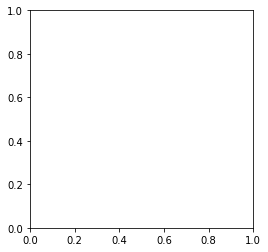

In [70]:
fig, ax = plt.subplots(1, figsize=(4, 4))

for xp, yp, c, m in zip(WellData.SH_Long, WellData.SH_Lat, WellData.P_Res, 
                        WellData.Marker):
    ax.scatter([xp], [yp], c=c, marker=m, s=125, alpha=0.8, edgecolor='k')

ax.grid()
plt.tight_layout()
ax.set_xlabel('Longitude', size=15)
ax.set_ylabel('Latitude', size=15)
ax.set_title('Darker Red = Higher Pressure')
,

In [101]:
WellData['color'] = WellData.Formation
WellData['marker'] = 'o'
WellData.color.replace({'Nan':'w',
                        'w1.alpha': 'm',
                        'shale.alpha':'r',
                        'upper.beta': 'xkcd:sky blue',
                        'middle.beta': 'g',
                        'lower.beta': 'b',
                        'upper.delta':'y'}, inplace=True)

In [119]:
WellData['YM'].min()

32.476395000000004

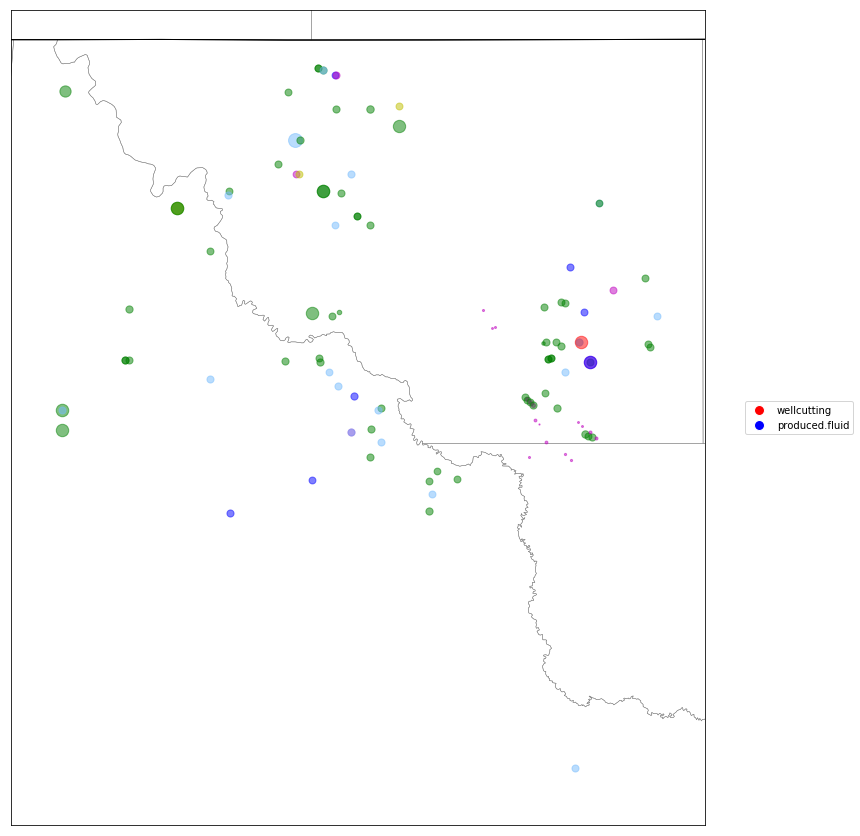

In [134]:
fig, ax = plt.subplots(figsize=(20,15))

Wells = WellData.groupby('Well.Name').first()
#Wells = Wells.loc[Wells.longitude < 0]
lat = list(Wells.SH_Lat.astype(float))
long = list(Wells.SH_Long.astype(float))

buffer = 0.05

map = Basemap(llcrnrlon=min(Wells.SH_Long)-buffer, urcrnrlon=max(Wells.SH_Long)+buffer,
                  lon_0=0.5*(min(Wells.SH_Long)+max(Wells.SH_Long)),
                  llcrnrlat=min(Wells.SH_Lat)-buffer, urcrnrlat=max(Wells.SH_Lat)+buffer,
                  lat_0=0.5*(min(Wells.SH_Lat)+max(Wells.SH_Lat)),
                  projection='tmerc')
# add county boundaries
map.readshapefile('/home/jovyan/my-conda-envs/qiime2-2019.1/share/basemap/cb_2017_us_county_500k',
                  'counties',drawbounds=True,
                  linewidth=0.45,color='gray')
# add state boundaries
map.readshapefile('/home/jovyan/my-conda-envs/qiime2-2019.1/share/basemap/st99_d00','states',
                  drawbounds=True,linewidth=1,color='black')

minPRes = WellData['P_Res'].min()
minYM = WellData['YM'].min()
minSWT = WellData['SWT'].min()

for i, r in Wells.iterrows():
    x, y = map(r.SH_Long, r.SH_Lat)
    #r.P_Res.min())
   # form = r.Formation
    #if 'w1.alpha' in form:
    map.plot(x, y, marker=r.marker, c=r.color, ms = r.Prop_ft/200, alpha=0.5)
   # if i in ['silvertip.76.7.unit.a.8h']:
    #    ax.annotate(i, (x+500, y+500))
    
# map.drawmapscale(min(long)+0.15, min(lat), 0.5*(min(long)+max(long)), 0.5*(min(lat)+max(lat)), 
#                  length=10, barstyle='simple', units='mi')

F0 = Line2D([],[], marker='o', color='w', markerfacecolor='red', label='wellcutting', markersize=10)
F1 = Line2D([],[], marker='o', color='w', markerfacecolor='blue', label='produced.fluid', markersize=10)
ax.legend(handles=[F0,F1],loc='center left', bbox_to_anchor=(1.05, 0.5))

#fig.savefig('../images/APC_cuttings_vs_fluids_map_QCed.png', dpi=300, bbox_inches='tight')

In [146]:
WellData.PRes = bpl.get_color_map(sample_md=WellData.P_Res,continuous=True, colormap='Reds').copy()

WellData.YM = bpl.get_color_map(sample_md=WellData.YM,continuous=True, colormap='Blues').copy()

WellData.CumOil_1Months_F = bpl.get_color_map(sample_md=WellData.CumOil_1Months_F, continuous=True, colormap='Greens').copy()


fig, ax = plt.subplots(1, figsize=(4, 4))

for xp, yp, c in zip(WellData.SH_Long, WellData.SH_Lat, WellData.PRes):
    ax.scatter([xp], [yp], c=c, marker=m, s=125, alpha=0.8, edgecolor='k')

ax.grid()
plt.tight_layout()
ax.set_xlabel('Longitude', size=15)
ax.set_ylabel('Latitude', size=15)
ax.set_title('Darker Red = Higher Pressure')
,
fig, ax = plt.subplots(1, figsize=(4, 4))

for xp, yp, c in zip(WellData.SH_Long, WellData.SH_Lat, WellData.YM):
    ax.scatter([xp], [yp], c=c, marker=m, s=125, alpha=0.8, edgecolor='k')

ax.grid()
plt.tight_layout()
ax.set_xlabel('Longitude', size=15)
ax.set_ylabel('Latitude', size=15)
ax.set_title('Darker Red = Higher Pressure')
,

fig, ax = plt.subplots(1, figsize=(4, 4))

for xp, yp, c in zip(WellData.SH_Long, WellData.SH_Lat, WellData.CumOil_1Months_F):
    ax.scatter([xp], [yp], c=c, marker=m, s=125, alpha=0.8, edgecolor='k')

ax.grid()
plt.tight_layout()
ax.set_xlabel('Longitude', size=15)
ax.set_ylabel('Latitude', size=15)
ax.set_title('Darker Red = Higher Pressure')
,

#fig.tight_layout()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [56]:
query = {'Well': {'$in': Wells}}

samples, data, features = get_sample_data(query)

The filtering function dropped 0 samples and 16460 features
The sample method dropped 1 samples with no sequence data.


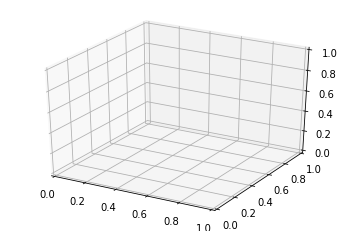

In [32]:
from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

In [57]:
#zdata = WellSurvey['MD']
#ydata = WellSurvey['Inclination']
#xdata = WellSurvey['Azimuth']
#ax = plt.axes(projection='3d')
#ax.scatter3D(xdata, ydata, zdata, cmap='Greens');

In [ ]:
ThresData = WellData